In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
!pip install -q albumentations

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.6 MB/s eta 0:00:00


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from huggingface_hub import login
login()

In [4]:
from datasets import load_dataset

dataset = load_dataset("segments/sidewalk-semantic")

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Let's take a look at this dataset in more detail. It consists of 1000 examples:

In [5]:
dataset = dataset["train"]

In [6]:
import numpy as np
from datasets import load_from_disk, concatenate_datasets, DatasetDict
from PIL import Image
from collections import defaultdict

In [7]:
def get_class_counts(dataset):

    class_counts = defaultdict(int)
    
    for example in dataset:
        annotation_array = np.array(example['label'])
        
        unique = np.unique(annotation_array)
        
        for class_id in unique:
            class_counts[class_id] += 1

    return dict(class_counts)

class_counts = get_class_counts(dataset)


In [8]:
class_counts

{1: 879,
 2: 982,
 3: 158,
 5: 686,
 7: 794,
 10: 933,
 18: 948,
 19: 180,
 20: 520,
 24: 138,
 25: 965,
 26: 472,
 28: 984,
 32: 196,
 33: 940,
 0: 104,
 21: 323,
 29: 506,
 15: 224,
 14: 34,
 31: 171,
 4: 315,
 30: 810,
 9: 159,
 27: 37,
 8: 283,
 12: 13,
 11: 74,
 17: 19,
 34: 66,
 16: 16,
 22: 31,
 23: 1,
 13: 5,
 6: 1}

In [10]:
def filter_categories(example):
    # Convert annotation image to a numpy array
    annotation_array = np.array(example['label'])
    # Extract the category IDs from the red channel
    # Find unique category IDs
    unique_categories = np.unique(annotation_array)
    mustIDX = [10,8, 26, 15]                                # kullanacağımız classlar
    for class_id in unique_categories:
        if class_id not in mustIDX:
            # Set all pixels of this class to 0
            annotation_array[annotation_array == class_id] = 1
            #print(f"Setting class {class_id} to 0")

    example['label'] = Image.fromarray(annotation_array)
    
    return example    

In [12]:
filtered = dataset.map(filter_categories)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
dataset = filtered

In [14]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

Let's look at this particular example.

In [15]:
train_ds[0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

In [16]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"segments/sidewalk-semantic"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

{0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


Let's visualize it:

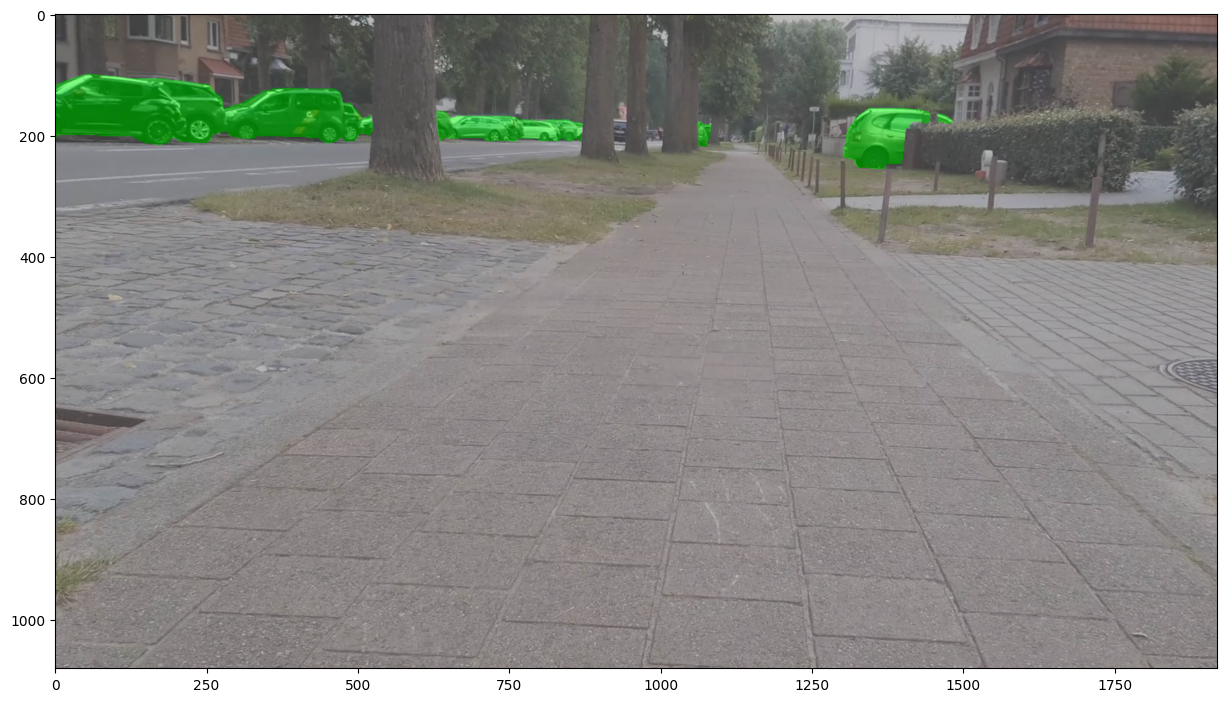

In [17]:
import numpy as np
import matplotlib.pyplot as plt
def color_palette():
    """Color palette that maps each class to RGB values.
    
    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]


# let's look at one example (images are pretty high resolution)
example = train_ds[1]
image = example['pixel_values']

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])
labels = [id2label[label] for label in np.unique(segmentation_map)]

palette = color_palette()
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Create PyTorch Dataset

Next, we create a standard PyTorch dataset. Each item of the dataset consists of the image and corresponding ground truth segmentation map. We also include the original image + map (before preprocessing) in order to compute metrics like mIoU.

In [18]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])
        
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [19]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# Convert mean and std from NumPy arrays to lists
ADE_MEAN = ADE_MEAN.tolist()
ADE_STD = ADE_STD.tolist()

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [20]:
image, segmentation_map, _, _ = train_dataset[0]


In [21]:
np.unique(segmentation_map)

array([ 1, 10], dtype=uint8)

In [22]:
np.unique(train_ds[0]["label"])

array([ 1, 10], dtype=uint8)

In [23]:
image, segmentation_map, _, _ = train_dataset[0]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


## Create PyTorch DataLoaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [24]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

2024-07-22 07:52:41.791027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch

train_dataloader = DataLoader(train_dataset, batch_size=14, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=14, shuffle=False, collate_fn=collate_fn)

## Verify data (!!)

Next, it's ALWAYS very important to check whether the data you feed to the model actually makes sense. It's one of the main principles of [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/), if you wanna debug your neural networks.

Let's check the first batch, and its content.

In [26]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([14, 3, 512, 512])
pixel_mask torch.Size([14, 512, 512])
mask_labels torch.Size([1, 512, 512])
class_labels torch.Size([1])
original_images (1080, 1920, 3)
original_segmentation_maps (1080, 1920)


In [27]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape 

(3, 512, 512)

In [28]:
batch["pixel_mask"][0]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

Again, let's denormalize an image and see what we got.

## Define model

Next, we define the model. We equip the model with pretrained weights from the 🤗 hub. We will replace only the classification head. For that we provide the id2label mapping, and specify to ignore mismatches keys to replace the already fine-tuned classification head.

In [29]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([36, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([36]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([36]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


See also the warning here: it's telling us that we are only replacing the class_predictor, which makes sense. As it's the only parameters that we will train from scratch.

## Train the model

It's time to train the model! We'll use the IoU metric to track progress.

In [25]:
import evaluate

metric = evaluate.load("mean_iou")

In [26]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(6):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 5:
      break

    pixel_values = batch["pixel_values"]
    
    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
  
  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

Epoch: 0


  0%|          | 0/58 [00:00<?, ?it/s]

Loss: 0.51318359375


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Mean IoU: 0.3737722520399117
Epoch: 1


  0%|          | 0/58 [00:00<?, ?it/s]

Loss: 0.10626211908877042


  0%|          | 0/15 [00:00<?, ?it/s]

Mean IoU: 0.6654552375730214
Epoch: 2


  0%|          | 0/58 [00:00<?, ?it/s]

Loss: 0.07009514881923444


  0%|          | 0/15 [00:00<?, ?it/s]

Mean IoU: 0.7055954536733372
Epoch: 3


  0%|          | 0/58 [00:00<?, ?it/s]

Loss: 0.05541146513886361


  0%|          | 0/15 [00:00<?, ?it/s]

Mean IoU: 0.7119104127129602
Epoch: 4


  0%|          | 0/58 [00:00<?, ?it/s]

Loss: 0.04716021932925804


  0%|          | 0/15 [00:00<?, ?it/s]

Mean IoU: 0.7126101249710391
Epoch: 5


  0%|          | 0/58 [00:00<?, ?it/s]

Loss: 0.04199656385299158


  0%|          | 0/15 [00:00<?, ?it/s]

Mean IoU: 0.722450986629659


In [237]:

from transformers import MaskFormerImageProcessor

# Create a preprocessor
processor = MaskFormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=True, do_rescale=True, do_normalize=True)


In [242]:
### Load Mean IoU metric
import evaluate
from tqdm.auto import tqdm

metrics = evaluate.load("mean_iou")
# Set model in evaluation mode
model.eval()
# Test set doesn't have annotations so we will use the validation set
ground_truths, preds = [], []
for idx in tqdm(range(len(test_ds))):
    image = test_ds[idx]["pixel_values"].convert("RGB")
    target_size = image.size[::-1]
    # Get ground truth semantic segmentation map
    annotation = np.array(test_ds[idx]["label"])
    # Replace null class (0) with the ignore_index (255) 
    annotation[annotation==1] = 255
    ground_truths.append(annotation)
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt").to(device)
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
 
    # Post-process results to retrieve semantic segmentation maps
    result = processor.post_process_semantic_segmentation(outputs, target_sizes=[target_size])[0]
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
results = metrics.compute(
    predictions=preds,
    references=ground_truths,
    num_labels=40,
    ignore_index=255
)
print(f"Mean IoU: {results['mean_iou']} | Mean Accuracy: {results['mean_accuracy']} | Overall Accuracy: {results['overall_accuracy']}")

  0%|          | 0/200 [00:00<?, ?it/s]

Mean IoU: 0.6661447101277462 | Mean Accuracy: 0.8615921544307534 | Overall Accuracy: 0.9608928761747962


In [243]:
# Prepare the output
scores = results["per_category_accuracy"]
class_id = -1
for score in scores:  # Adjust 'start=1' based on your id2label indexing
    class_id = class_id + 1
    if np.isnan(score):
        # Option to skip NaN values
        continue
 
    if class_id:

        class_name = id2label.get(class_id, "Unknown Class")
        print(f"Class ID: {class_id}, Class Name: {class_name}, Score: {score}")

Class ID: 8, Class Name: human-person, Score: 0.9126925747643203
Class ID: 10, Class Name: vehicle-car, Score: 0.9805151524670928
Class ID: 15, Class Name: vehicle-bicycle, Score: 0.8370907487668828
Class ID: 26, Class Name: object-trafficsign, Score: 0.7160701417247177


In [234]:
results

{'mean_iou': 0.7026992594592308,
 'mean_accuracy': 0.9031818834241014,
 'overall_accuracy': 0.962256159518042,
 'per_category_iou': array([       nan, 0.        ,        nan,        nan,        nan,
               nan,        nan,        nan, 0.90680181,        nan,
        0.9711813 ,        nan,        nan,        nan,        nan,
        0.85563164,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan, 0.77988156,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan]),
 'per_category_accuracy': array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.91581732,        nan,
        0.97253869,        nan,        nan,        nan,        nan,
        0.94273206,        nan,        nan,        nan,        nan,
               nan,       

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of a test batch.

In [34]:

from transformers import MaskFormerImageProcessor

# Create a preprocessor
processor = MaskFormerImageProcessor(ignore_index=0, do_reduce_labels=True, do_resize=True, do_rescale=True, do_normalize=True)


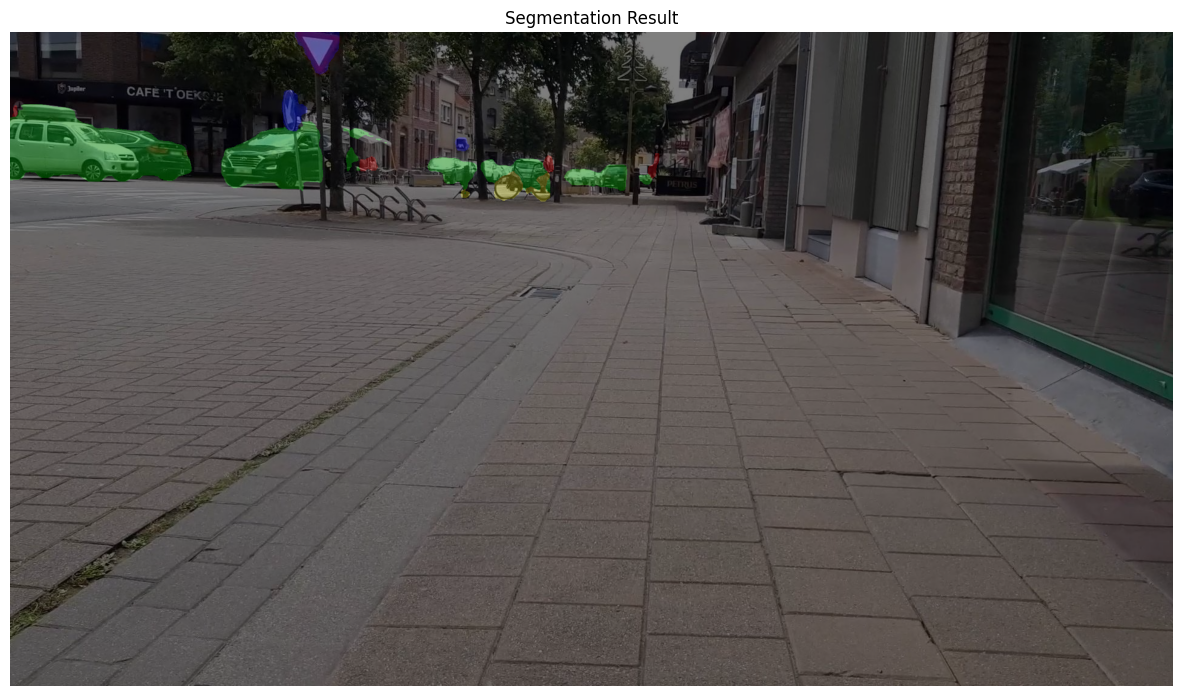

Class ID to Color and Name Mapping:
Class ID: 8, Color: [128, 0, 0], Name: human-person
Class ID: 10, Color: [0, 128, 0], Name: vehicle-car
Class ID: 15, Color: [128, 128, 0], Name: vehicle-bicycle
Class ID: 26, Color: [0, 0, 128], Name: object-trafficsign


In [109]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define your custom colors for the classes
custom_palette = {
   # 0: [0, 0, 0],       # Background
    #1: [66, 10, 70],       # Background
    8: [128, 0, 0],     # Class 1 person kırmızı
    10: [0, 128, 0],     # Class 2 car  yeşil
    15: [128, 128, 0],   # Class 3 turuncu biisklşet
    26: [0, 0, 128],     # Class 4 tabela 
}


# Use a random test image
image_index = random.randint(0, len(test_ds) - 1)
image = test_ds[image_index]["pixel_values"].convert("RGB")
target_size = image.size[::-1]

# Preprocess image
inputs = processor(images=image, return_tensors="pt").to(device)

# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs.to(device))

predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

# Visualization
seg = predicted_semantic_map.cpu().detach().numpy()
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)

# Apply the custom color palette
for label, color in custom_palette.items():
    color_seg[seg == label, :] = color

# Show image + mask
image_np = np.array(image)
blended_img = Image.blend(Image.fromarray(image_np), Image.fromarray(color_seg), alpha=0.5)

plt.figure(figsize=(15, 10))
plt.imshow(blended_img)
plt.title("Segmentation Result")
plt.axis('off')
plt.show()

# Print class ID to color and name mapping
print("Class ID to Color and Name Mapping:")
for class_id, color in custom_palette.items():
    print(f"Class ID: {class_id}, Color: {color}, Name: {id2label[class_id]}")


In [73]:
np.unique(predicted_semantic_map.cpu())

array([ 1,  8, 10, 15, 26])

background class id is 1 

In [38]:
# background class is 1 
predicted_semantic_map

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')

In [39]:
model.save_pretrained("sidewalk_v1")